In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(10, 10) # зададим размер картинки
data = pd.read_csv('D:\clients.csv', sep=',')


Подготовим данные, как в прошлый раз



In [2]:
data = data.drop(['month', 'phone_operator', 'product_type', 'region'], axis='columns')

def gender_oppression(gender):
    if gender == 'male':
        return 1
    return 0

data['sex'] = data['sex'].apply(gender_oppression)

def rename(edu):
    if edu == 'Incomplete secondary education':
        return 0
    if edu == 'Secondary education':
        return 1
    if edu == 'Secondary special education':
        return 2
    if edu == 'Incomplete higher education':
        return 3
    if edu == 'Higher education':
        return 4
    if edu == 'PhD Degree':
        return 5
    return 6

data['education'] = data['education'].apply(rename)

def rename(fs):
    if fs == 'Another':
        return 0
    if fs == 'Unmarried':
        return 1
    if fs == 'Married':
        return 2
    return 3

data['family_status'] = data['family_status'].apply(rename)

data.head()

,credit_amount,credit_term,age,sex,education,having_children_flg,income,family_status,is_client,bad_client_target
0,7000,12,39,1,2,0,21000,0,0,0
1,19000,6,20,1,2,1,17000,0,1,0
2,29000,12,23,0,2,0,31000,0,0,0
3,10000,12,30,1,2,1,31000,1,1,0
4,14500,12,25,0,4,0,26000,2,1,0



Поделим выборку

In [3]:
X = data[data.columns[:-1]]
y = data['bad_client_target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

СТРУКТУРА ДАННЫХ
Посмотрим на распределения и возможные зависимости признаков.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sex', ylabel='count'>

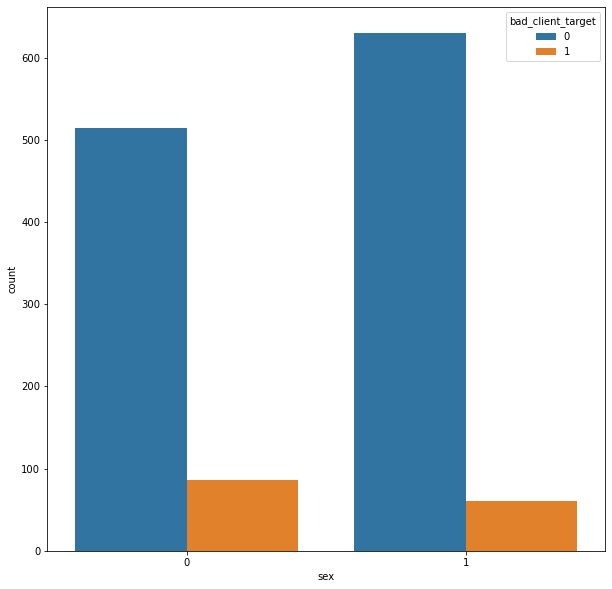

In [4]:
sns.countplot(X_train['sex'], hue=y_train)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='count'>

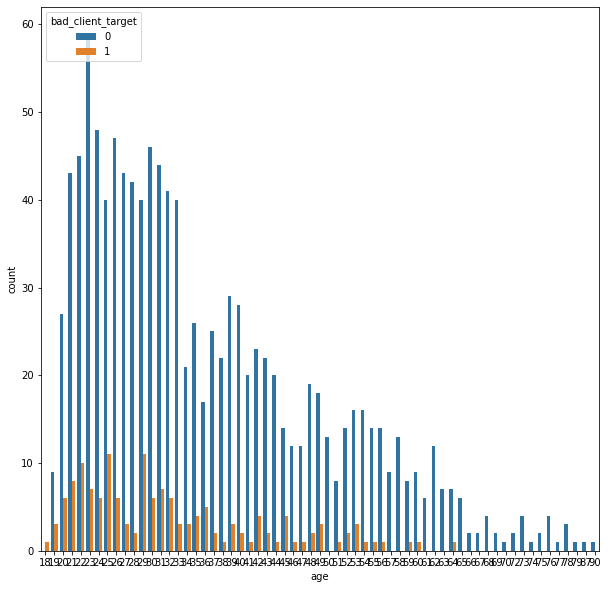

In [5]:
sns.countplot(X_train['age'], hue=y_train)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='credit_amount', ylabel='count'>

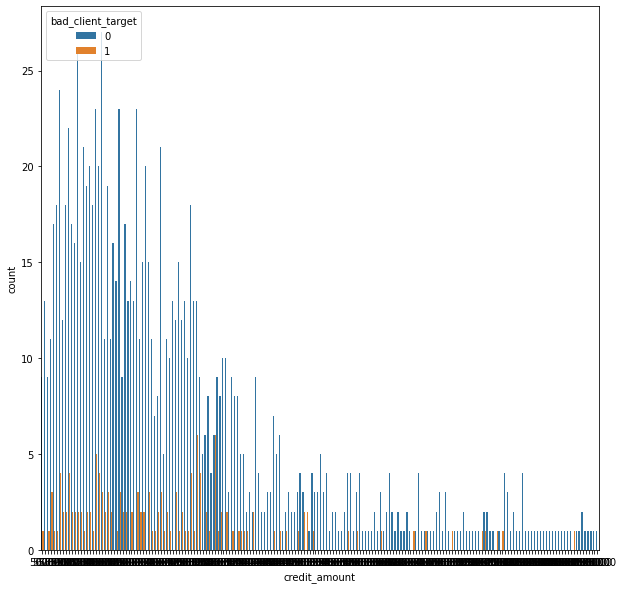

In [6]:
sns.countplot(X_train['credit_amount'], hue=y_train)


Наши переменные не дают точной оценки, является ли клиент неплатежеспособным.

А как же распределены признаки друг относительно друга?

<ipython-input-7-58dc3a760c64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_pairgrid['bad_client_target'] = y_train


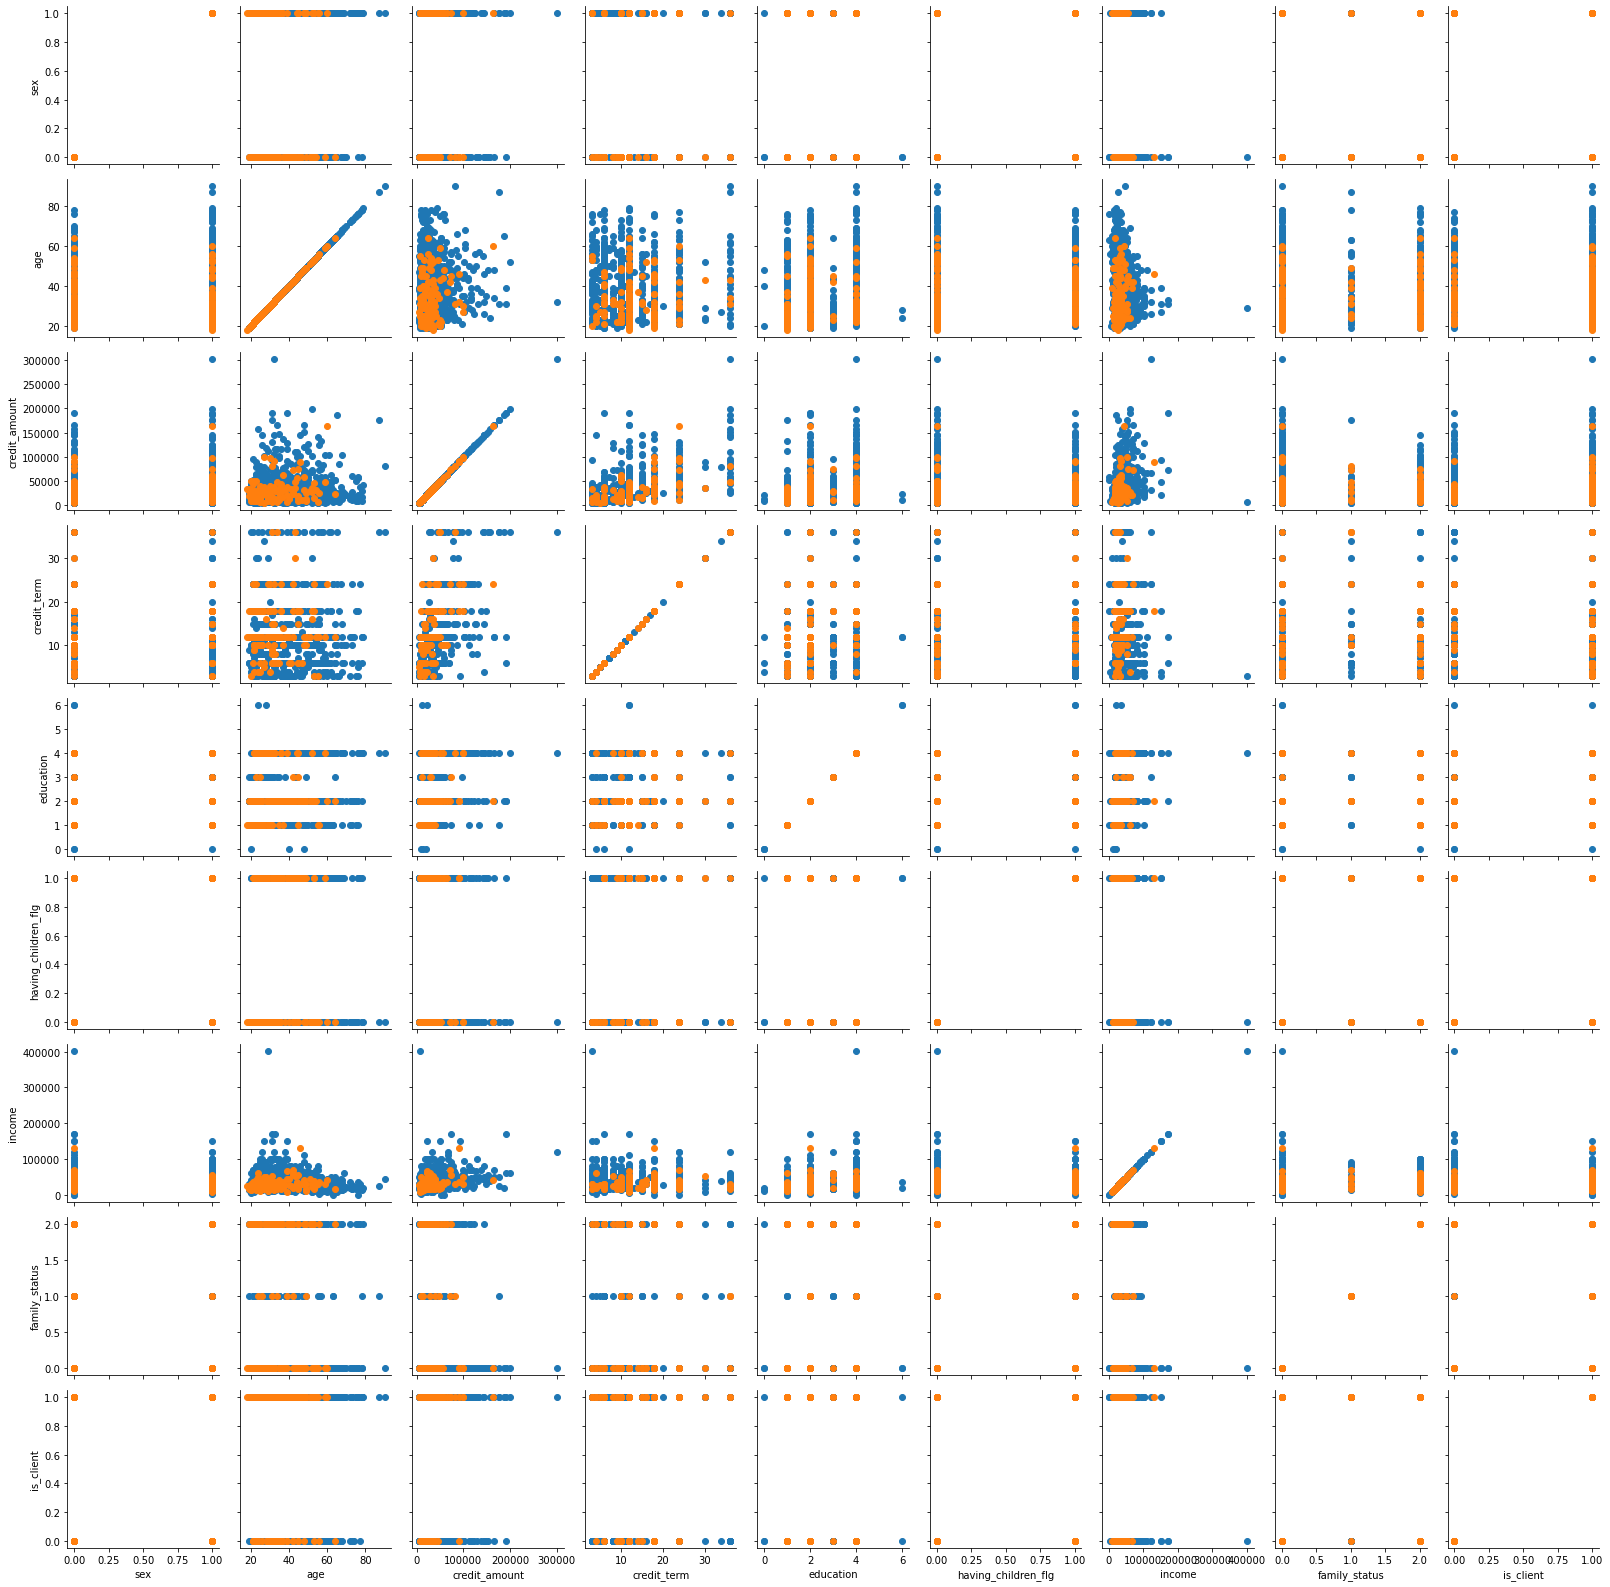

In [7]:
df_for_pairgrid = X_train[['sex', 'age', 'credit_amount', 'credit_term', 'education', 'having_children_flg', 'income', 'family_status', 'is_client']]
df_for_pairgrid['bad_client_target'] = y_train

sns.PairGrid(df_for_pairgrid, hue='bad_client_target').map(plt.scatter)

ВЫБРОСЫ

<AxesSubplot:xlabel='bad_client_target', ylabel='income'>

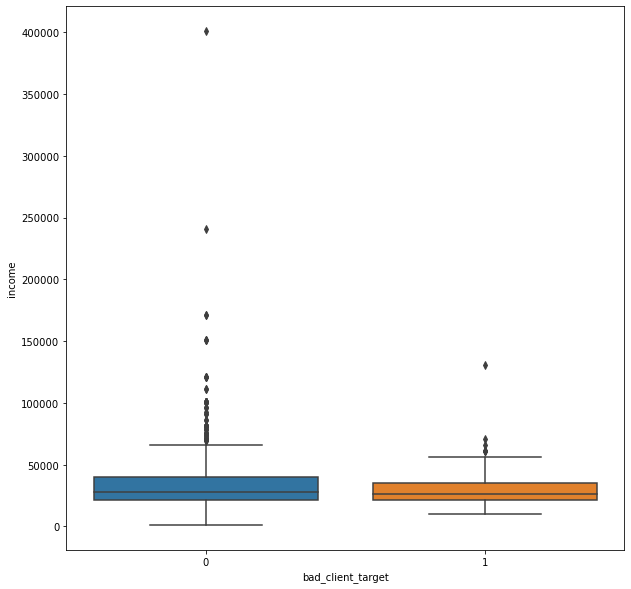

In [8]:
writingscore = pd.read_csv('D:clients.csv', sep=',')['income'].apply(lambda x: x if x >= 0 else x / 500)
sns.boxplot(x=y, y=writingscore)

А на графике-скрипке можно посмотреть еще и на плотность распределения величины.

<AxesSubplot:xlabel='bad_client_target', ylabel='income'>

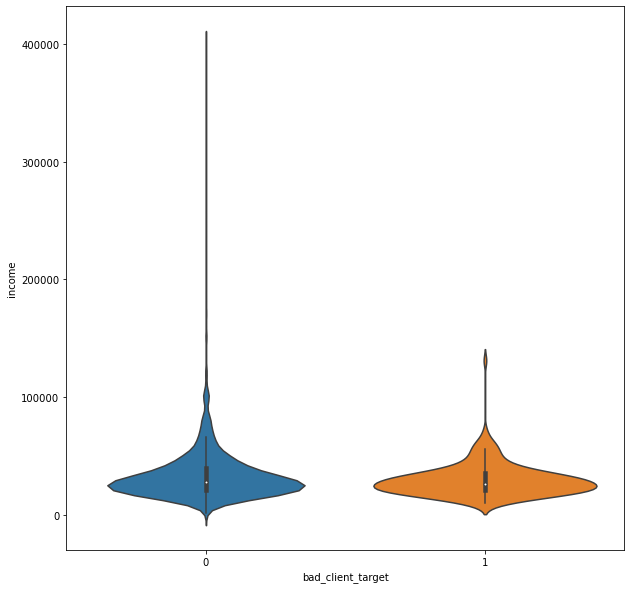

In [9]:
sns.violinplot(x=y, y=writingscore)

Качество алгоритма до нормализации: 0.8863109048723898
Качество алгоритма после нормализации: 0.8863109048723898


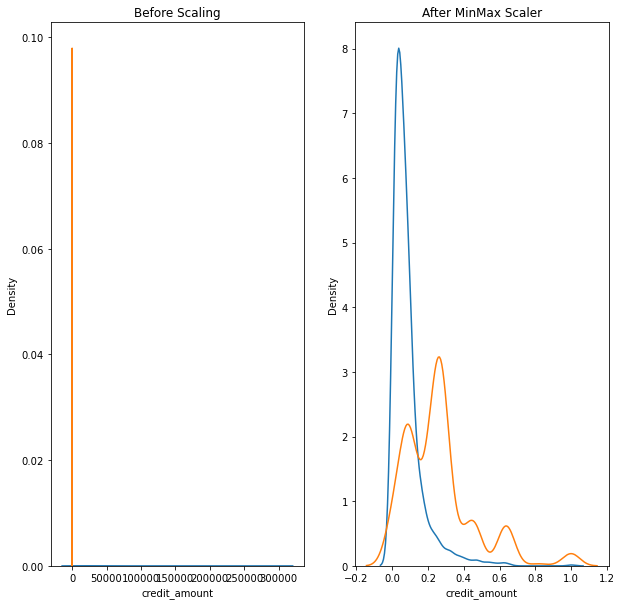

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=12).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=14).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['credit_amount'], ax=ax1)
sns.kdeplot(X_train['credit_term'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['credit_amount'], ax=ax2)
sns.kdeplot(X_train_scaled['credit_term'], ax=ax2)
plt.show()

ПОДБОР АЛГОРИТМА

Не всегда можно понять по визуализации данных, какой алгоритм может хорошо сработать. Чтобы понять, над какой моделью можно работать, посмотрим на качество на нескольких простых моделях.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.8074245939675174
SGDClassifier 0.8863109048723898
SVC 0.8863109048723898
GaussianNB 0.8723897911832946
KNeighborsClassifier 0.8747099767981439


Метод опорных векторов и стохастический градиентный классификатор показали наилучший результат.

ПРО СТРАТИФИКАЦИЮ

Посмотрим на распределение классов в тренировочной выборке.

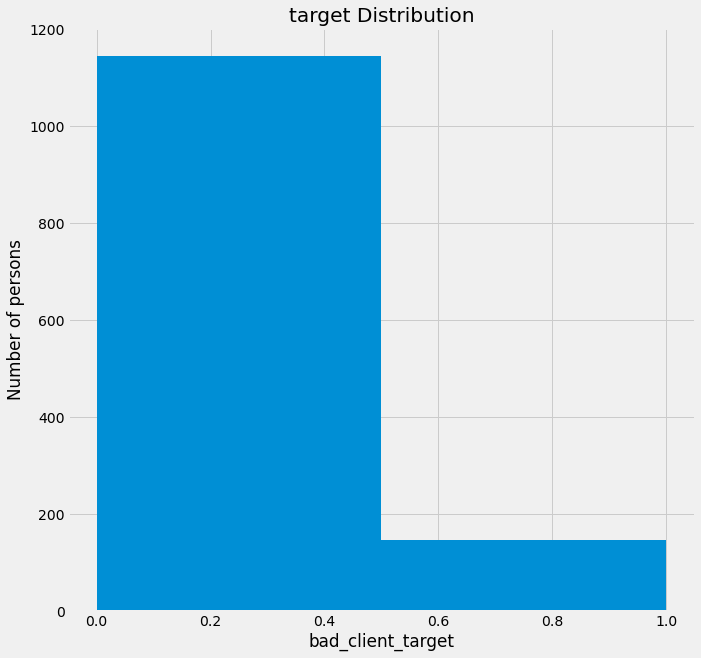

In [12]:
plt.style.use('fivethirtyeight')
plt.hist(y_train, bins=2);
plt.xlabel('bad_client_target'); plt.ylabel('Number of persons');
plt.title('target Distribution');


Рассмотрим простейший случай

In [13]:
from sklearn.metrics import accuracy_score

a = np.ones(y_test.shape[0])
accuracy_score(y_test, a)

0.1136890951276102

Увеличим количество примеров из недоминантного класса.

In [14]:
X_train_scaled.reset_index(inplace=True, drop=True)
y_train.reset_index(drop=True, inplace=True)
dead = X_train_scaled[y_train == 0]
X_train_strat = pd.concat([X_train_scaled, dead, dead], ignore_index=True)
y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                          ignore_index=True)
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_strat, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.1136890951276102
SGDClassifier 0.1136890951276102
SVC 0.1136890951276102
GaussianNB 0.11600928074245939
KNeighborsClassifier 0.1136890951276102



После стратификации лучший результат показал алгоритм Гаусса

МЕТРИКИ КАЧЕСТВА

Посмотрим на предсказания константного классификатора

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.1136890951276102
Precision: 0.1136890951276102
Recall: 1.0
ROC AUC: 0.5
PRC AUC: 0.5568445475638051
F1: 0.20416666666666666
F0.5: 0.13818386914833614
F2: 0.39074960127591707


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
